In [28]:
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers

In [29]:
num_classes = 8
input_shape = (64, 64, 3)
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 32
num_epochs = 10
image_size = 64
patch_size = 12
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 8
transformer_units = [projection_dim * 2, projection_dim]
transformer_layers = 2
mlp_head_units = [1024, 512]

In [30]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [31]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images = images,
            sizes = [1, self.patch_size, self.patch_size, 1],
            strides = [1, self.patch_size, self.patch_size, 1],
            rates = [1, 1, 1, 1],
            padding = "VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

In [32]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units = projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim = num_patches, output_dim = projection_dim
        )

    def call(self, patch):
        positions = tf.range(start = 0, limit = self.num_patches, delta = 1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded


In [33]:
def create_vit_classifier():
    inputs = layers.Input(shape=(image_size, image_size, 3))
    augmented = data_augmentation(inputs)
    patches = Patches(patch_size)(augmented)
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)
    
    for _ in range(transformer_layers):
        x1 = layers.LayerNormalization(epsilon = 1e-6)(encoded_patches)
        attention_output = layers.MultiHeadAttention(
            num_heads = num_heads, 
            key_dim = projection_dim, 
            dropout = 0.1
        )(x1, x1)
        x2 = layers.Add()([attention_output, encoded_patches])
        x3 = layers.LayerNormalization(epsilon = 1e-6)(x2)
        x3 = mlp(x3, hidden_units = transformer_units, dropout_rate = 0.1)
        encoded_patches = layers.Add()([x3, x2])

    representation = layers.LayerNormalization(epsilon = 1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    features = mlp(representation, hidden_units = mlp_head_units, dropout_rate = 0.5)
    logits = layers.Dense(num_classes)(features)
    model = keras.Model(inputs = inputs, outputs = logits)
    
    return model

In [34]:
train_dir = "D:/Data(CD)/ocular/train"
test_dir = "D:/Data(CD)/ocular/test"
validation_dir = "D:/Data(CD)/ocular/validation"

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    image_size=(image_size, image_size),
    label_mode='int'
)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    validation_dir,
    batch_size=batch_size,
    image_size=(image_size, image_size),
    label_mode='int'
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    batch_size=batch_size,
    image_size=(image_size, image_size),
    label_mode='int'
)

Found 3000 files belonging to 8 classes.
Found 799 files belonging to 8 classes.
Found 200 files belonging to 8 classes.


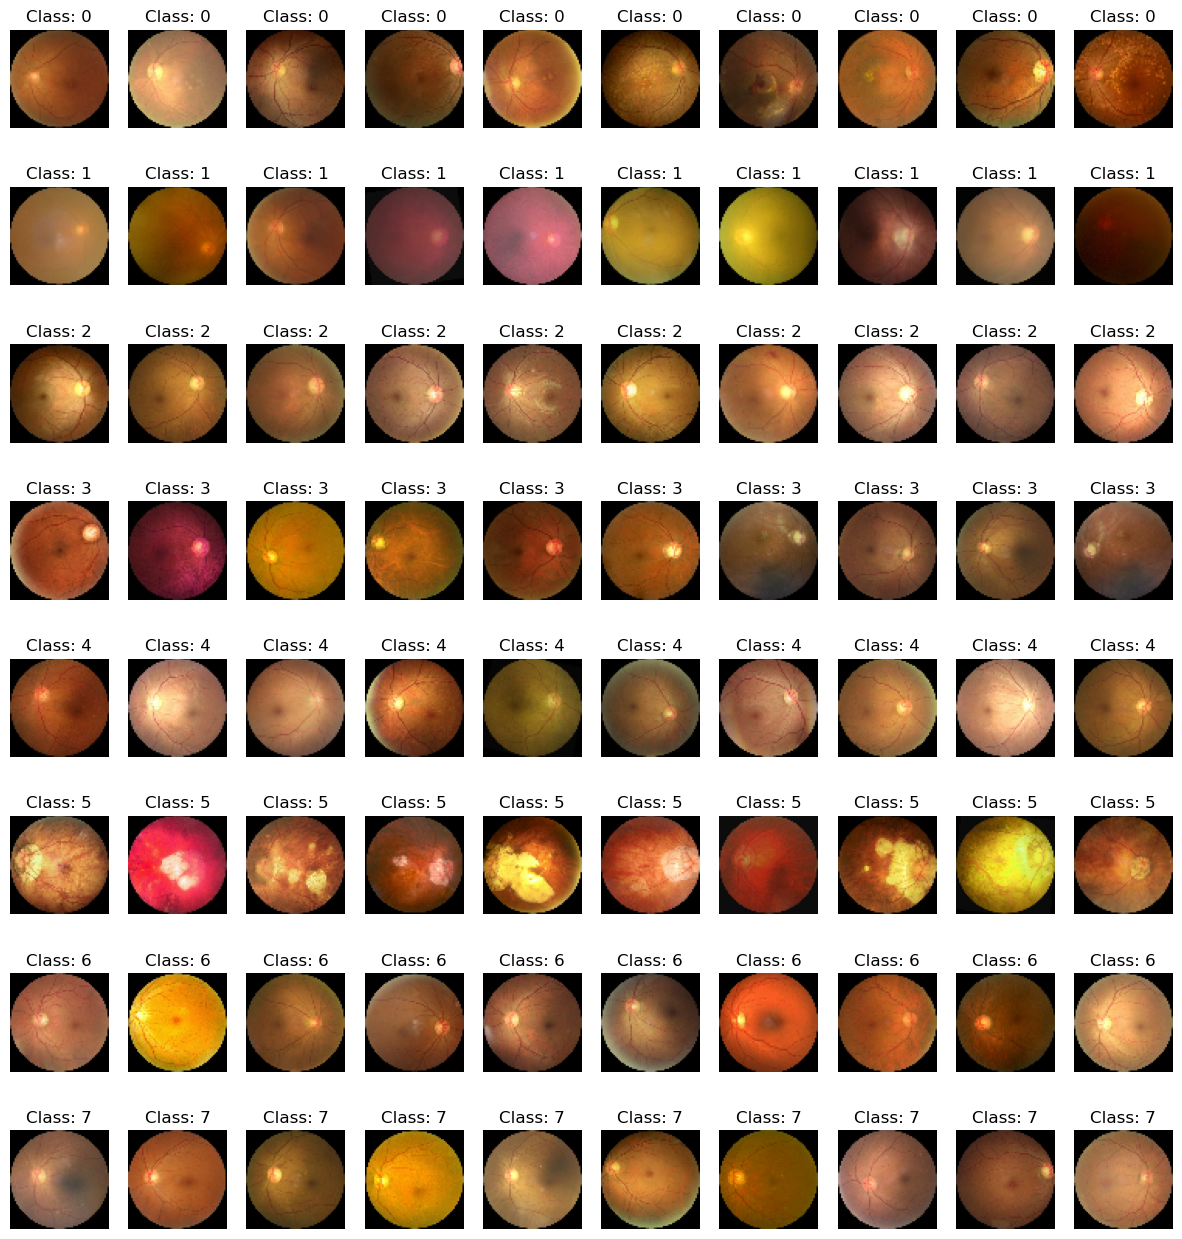

In [35]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Function to display limited images for each class in separate blocks
def display_separate_blocks_by_class(dataset, num_images_per_class=10):
    # Create a dictionary to store limited images for each class
    class_images = {}

    # Iterate through the dataset and store limited images for each class
    for images, labels in dataset:
        for i in range(len(images)):
            label = int(labels[i].numpy())
            if label not in class_images:
                class_images[label] = []
            if len(class_images[label]) < num_images_per_class:
                class_images[label].append(images[i].numpy().astype("uint8"))

    # Display limited images for each class in separate blocks
    num_classes = len(class_images)
    fig, axs = plt.subplots(num_classes, num_images_per_class, figsize=(15, 2*num_classes))

    for i in range(num_classes):
        for j in range(num_images_per_class):
            axs[i, j].imshow(class_images[i][j])
            axs[i, j].set_title(f"Class: {i}")
            axs[i, j].axis("off")

    plt.show()

# Display limited images for each class from the training dataset in separate blocks
display_separate_blocks_by_class(train_dataset, num_images_per_class=10)


In [36]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor = 0.02),
        layers.RandomZoom(height_factor = 0.2, width_factor = 0.2),
    ],
    name = "data_augmentation",
)

In [37]:
train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training = True), y))

In [38]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate = learning_rate, 
        weight_decay = weight_decay)
    
    model.compile(optimizer = optimizer, 
                  loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True),
                  metrics = [keras.metrics.SparseCategoricalAccuracy(name = "accuracy"),
                           keras.metrics.SparseTopKCategoricalAccuracy(5, name = "top-5-accuracy"), ])
    
    checkpoint_filepath = "checkpoint_dir/model_checkpoint"
    
    checkpoint_callback = keras.callbacks.ModelCheckpoint(checkpoint_filepath, 
                                                          monitor = "val_accuracy",
                                                          save_best_only = True, 
                                                          save_weights_only = True)
    history = model.fit(
        train_dataset, 
        epochs = num_epochs, 
        validation_data = validation_dataset,                   
        callbacks = [checkpoint_callback]
    )
    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(test_dataset)
    
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")
    
    return history

import os
os.makedirs("checkpoint_dir", exist_ok=True)

In [39]:
vit_classifier = create_vit_classifier()

history = run_experiment(vit_classifier)

Epoch 1/10
94/94 [==============================] - 20s 135ms/step - loss: 2.5775 - accuracy: 0.1303 - top-5-accuracy: 0.6223 - val_loss: 2.0852 - val_accuracy: 0.1252 - val_top-5-accuracy: 0.6546
Epoch 2/10
94/94 [==============================] - 12s 124ms/step - loss: 2.1500 - accuracy: 0.1337 - top-5-accuracy: 0.6550 - val_loss: 2.0707 - val_accuracy: 0.1327 - val_top-5-accuracy: 0.6696
Epoch 3/10
94/94 [==============================] - 12s 124ms/step - loss: 2.1287 - accuracy: 0.1317 - top-5-accuracy: 0.6397 - val_loss: 2.0602 - val_accuracy: 0.1640 - val_top-5-accuracy: 0.6683
Epoch 4/10
94/94 [==============================] - 12s 122ms/step - loss: 2.0892 - accuracy: 0.1457 - top-5-accuracy: 0.6883 - val_loss: 2.0431 - val_accuracy: 0.1715 - val_top-5-accuracy: 0.7084
Epoch 5/10
94/94 [==============================] - 12s 122ms/step - loss: 2.0778 - accuracy: 0.1583 - top-5-accuracy: 0.6860 - val_loss: 2.0313 - val_accuracy: 0.1790 - val_top-5-accuracy: 0.6934
Epoch 6/10
94/9

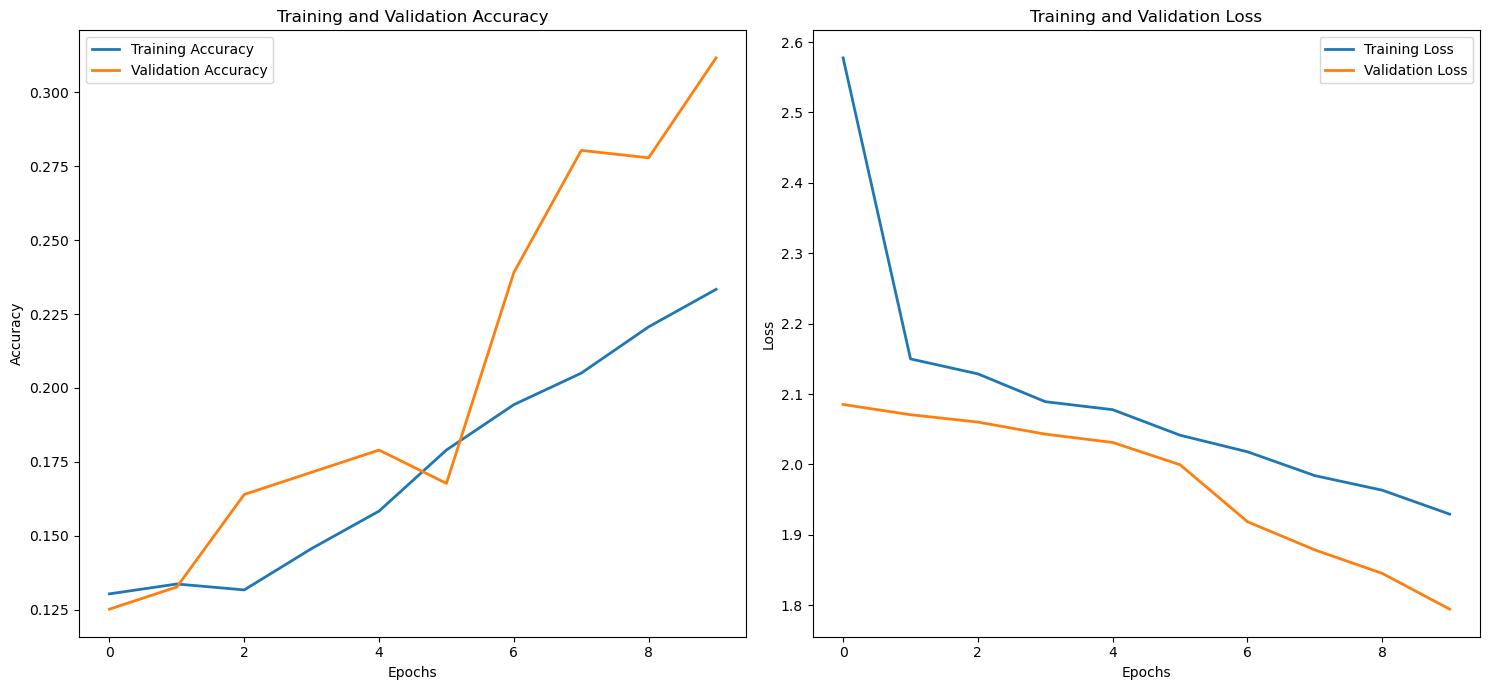

In [40]:
plt.figure(figsize=(15, 7))

# Plotting accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label = 'Training Accuracy', linewidth = 2)
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy', linewidth = 2)
plt.legend()
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label = 'Training Loss', linewidth = 2)
plt.plot(history.history['val_loss'], label = 'Validation Loss', linewidth = 2)
plt.legend()
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()

In [41]:
# Load best weights
vit_classifier.load_weights("checkpoint_dir/model_checkpoint")

# Evaluate on the test data
test_loss, test_accuracy, test_top_5_accuracy = vit_classifier.evaluate(test_dataset)

print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

print(f"Test top 5 accuracy: {round(test_top_5_accuracy * 100, 2)}%")

7/7 [==============================] - 0s 27ms/step - loss: 1.8001 - accuracy: 0.2850 - top-5-accuracy: 0.8450
Test accuracy: 28.5%
Test top 5 accuracy: 84.5%
